# Final project

### Задачи:
1. Построить рекомендательную систему, благодаря которой можно будет предлагать клиентам интересные им курсы.
2. Составить итоговую таблицу с рекомендациями, снабдив её необходимыми комментариями.

<div class="alert alert-block alert-info">
<b>Сколько клиентов покупали курсы?</div>
<div class="alert alert-block alert-success">
<pre>
SELECT COUNT(DISTINCT user_id) 
FROM final.cart_items ci 
JOIN final.carts c ON ci.cart_id=c.id
WHERE ci.resource_type = 'Course' AND c.state = 'successful'
</pre>    
<b>Ответ:</b> 49006
</div>

<div class="alert alert-block alert-info">
<b>Сколько всего есть различных курсов?</div>
<div class="alert alert-block alert-success">
<pre>
SELECT COUNT(DISTINCT resource_id) 
FROM final.cart_items ci 
JOIN final.carts c ON ci.cart_id=c.id
WHERE ci.resource_type = 'Course' AND c.state = 'successful'
</pre>    
<b>Ответ:</b> 127
</div>

<div class="alert alert-block alert-info">
<b>Каково среднее количество купленных курсов на одного клиента?</div>
<div class="alert alert-block alert-success">
<pre>
SELECT ROUND(COUNT(ci.resource_id)/COUNT(distinct c.user_id)::numeric,2) AS avarage_purchased_courses
FROM final.cart_items ci 
JOIN final.carts c ON ci.cart_id=c.id
WHERE ci.resource_type = 'Course' AND c.state = 'successful'
</pre>    
<b>Ответ:</b> 1.44
</div>

<div class="alert alert-block alert-info">
<b>Сколько клиентов купили более одного курса?</div>
<div class="alert alert-block alert-success">
<pre>
WITH cc AS 
(SELECT c.user_id,
        COUNT(DISTINCT ci.resource_id) AS course_count
FROM final.cart_items ci 
JOIN final.carts c ON ci.cart_id=c.id
WHERE ci.resource_type = 'Course' AND c.state = 'successful'
GROUP BY 1)
SELECT COUNT(user_id)
FROM cc
WHERE course_count>1
</pre>    
<b>Ответ:</b> 12656
</div>

In [1]:
# Подключение необходимых бибилотек
import pandas as pd
import numpy as np
import itertools as it
from collections import Counter

In [2]:
# Подключение к базе данных
import psycopg2
import psycopg2.extras
def getData():
    query = '''with a as
(
select user_id, resource_id
from final.cart_items ci 
	join final.carts c on ci.cart_id=c.id
where state='successful' and resource_type='Course'
group by 1, 2
),
b as 
(
select user_id, count(resource_id) as cc
from a
group by user_id
)
select b.user_id, a.resource_id
from b
 join a on b.user_id = a.user_id
where cc > 1
order by 1, 2
    '''.format()
    conn = psycopg2.connect(dbname='skillfactory',
                            user='skillfactory',
                            host='84.201.134.129',
                            password='cCkxxLVrDE8EbvjueeMedPKt',
                            port=5432)
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    dict_cur.close()
    conn.close()
    return data
data=pd.DataFrame(getData())
data

,user_id,resource_id
0,51,516
1,51,1099
2,6117,356
3,6117,357
4,6117,1125
...,...,...
34069,2188926,515
34070,2188926,743
34071,2190141,756
34072,2190141,794


In [3]:
# Группировка по user_id для получения наборов курсов по каждому пользователю
data_gr = data.groupby(['user_id'])['resource_id'].apply(lambda x: list(np.unique (x))).reset_index()
data_gr

,user_id,resource_id
0,51,"[516, 1099]"
1,6117,"[356, 357, 1125]"
2,10275,"[553, 1147]"
3,10457,"[361, 1138]"
4,17166,"[356, 357]"
...,...,...
12651,2179430,"[566, 750]"
12652,2186581,"[794, 864, 1129]"
12653,2187601,"[356, 553, 571, 765, 912]"
12654,2188926,"[515, 743]"


In [4]:
# Создаем список пар курсов
list_courses = []
for resource in data_gr['resource_id']:
    for pair in it.combinations(resource, 2):
        list_courses.append(pair)
num = len(set(list_courses))
print('В покупках клиентов встречается {} различных пар курсов.'.format(num))

В покупках клиентов встречается 3989 различных пар курсов.


In [5]:
# Добавляем счетчик 
pairs = Counter([pair for pair in list_courses])
pairs

Counter({(516, 1099): 25,
         (356, 357): 100,
         (356, 1125): 44,
         (357, 1125): 52,
         (553, 1147): 16,
         (361, 1138): 40,
         (1125, 1140): 1,
         (551, 745): 138,
         (553, 745): 212,
         (551, 1138): 14,
         (553, 568): 83,
         (514, 517): 10,
         (514, 566): 138,
         (517, 566): 21,
         (363, 511): 99,
         (363, 562): 77,
         (363, 563): 33,
         (511, 562): 55,
         (511, 563): 19,
         (562, 563): 53,
         (568, 745): 102,
         (509, 553): 48,
         (509, 745): 59,
         (1125, 1144): 22,
         (509, 568): 46,
         (509, 672): 5,
         (568, 672): 4,
         (516, 552): 12,
         (356, 552): 7,
         (357, 571): 112,
         (509, 516): 35,
         (516, 568): 54,
         (513, 1141): 34,
         (571, 1125): 122,
         (551, 552): 177,
         (551, 744): 16,
         (551, 862): 8,
         (552, 744): 8,
         (552, 862): 6,
         (55

In [6]:
popular = {k:v for k,v in pairs.items() if v == max(pairs.values())}
print('{} - самая популярная пара курсов.'.format(popular.keys()))

dict_keys([(551, 566)]) - самая популярная пара курсов.


In [7]:
# Сортируем список по счетчику
sorted_pairs = {k:v for k,v in sorted(pairs.items())}

In [8]:
# Рекомендательная функция, которая оставляет 2 самые популярные пары
def recommend(course):
    course_list = []
    for i in sorted_pairs.keys():
        if i[0] == course:
            course_list.append((i, sorted_pairs[i]))
    sorted_course_list = sorted(course_list, key=lambda x: x[1], reverse = True)
    return sorted_course_list[:2]

In [9]:
# Список уникальных курсов
courses = data['resource_id'].unique()
courses

array([ 516, 1099,  356,  357, 1125,  553, 1147,  361, 1138, 1140,  551,
        745,  568,  514,  517,  566,  363,  511,  562,  563,  509, 1144,
        672,  552,  571,  513, 1141,  744,  862,  679,  750,  800,  569,
        840,  765, 1187, 1100, 1103,  502,  564,  865,  764, 1139, 1186,
        366,  367,  519,  809,  515,  912,  489,  523,  864, 1101, 1146,
        776,  671,  753,  829,  490, 1102,  803,  659,  909,  794,  518,
        907,  777,  908,  360,  813,  835,  741,  752,  814, 1115, 1116,
       1161,  863,  743,  504,  572,  810, 1124, 1128,  742, 1104,  503,
        664,  507,  570, 1185, 1198,  365,  359,  791, 1156,  362, 1184,
        911,  358, 1160,  757,  508, 1181,  755, 1145, 1188,  756,  866,
        749,  368,  364,  834, 1152,  670, 1199,  836, 1201, 1129, 1182,
        902,  837, 1200,  833,  830])

In [10]:
# Будущий датафрейм с рекомендациями
recommendations = pd.DataFrame(columns = ['Рекомендация №1', 'Рекомендация №2'])

# Заполняем датафрейм рекомндациями для каждого из уникальных курсов
for i in courses:
    if len(recommend(i)) == 2:
        recommendations.loc[i] = [recommend(i)[0][0][1], recommend(i)[1][0][1]]
    elif len(recommend(i)) == 1:
        recommendations.loc[i] = [recommend(i)[0][0][1], np.nan]
    else:
        recommendations.loc[i] = [np.nan, np.nan]
recommendations = recommendations.rename_axis('Основной курс').reset_index()
recommendations

,Основной курс,Рекомендация №1,Рекомендация №2
0,516,745,553
1,1099,1139,1187
2,356,571,357
3,357,571,1125
4,1125,1186,1144
...,...,...,...
121,902,NaN,NaN
122,837,840,1161
123,1200,NaN,NaN
124,833,NaN,NaN


In [11]:
recommendations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Основной курс    126 non-null    int64 
 1   Рекомендация №1  117 non-null    object
 2   Рекомендация №2  112 non-null    object
dtypes: int64(1), object(2)
memory usage: 3.1+ KB


Подобрано 117 из 126 Рекомендаций №1 и 112 из 126 Рекомендаций №2. Необходимо заменить мало встречаемые курсы и Nan на более популярный курс, чтобы достигнуть поставленной цели: увеличение среднего чека. Поскольку операции выше показали, что самый популярная пара курсов оказалась (551, 566), ее и будем использовать для замены.

Однако необходимо понять, какое число покупки пар курсов считать минимальным:

In [12]:
# Создаем датафрейм с частотой покупки пары курсов.
li = []
for i in sorted_pairs.values():
    li.append(i)
li = pd.DataFrame(li, columns = ['num'])

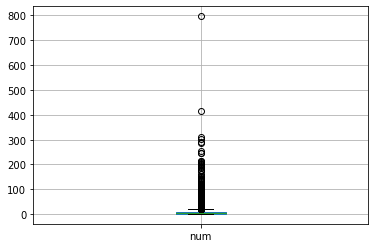

In [13]:
boxplot = li.boxplot(column = 'num')

In [14]:
li.mean()

num    10.031838
dtype: float64

In [15]:
li.median()

num    3.0
dtype: float64

In [16]:
li.std()

num    26.355998
dtype: float64

In [17]:
value = li.quantile(q=0.9, axis=0, numeric_only=True, interpolation='midpoint')
round(value,1)

num    22.0
Name: 0.9, dtype: float64

Существует сильный разброс значений судя по "ящику с усами" и стандартному отклонению. Превышение среднего значение над медианным доказывает достаточное количество больших значений (выбросов). Существует много пар курсов, которые покупали очень редко из-за чего основная часть boxplot смещена к нулю.
Видим, что 90% пар курсов встречаются 22 раза. Это значение будем считать минимальной границей.

Теперь внесем изменения в код:

In [18]:
recommendations = pd.DataFrame(columns = ['Рекомендация №1', 'Рекомендация №2'])

for i in courses:
    if len(recommend(i)) == 2:
        if recommend(i)[0][1]>=22 & recommend(i)[1][1]>=22:
            recommendations.loc[i] = [recommend(i)[0][0][1], recommend(i)[1][0][1]]
        elif recommend(i)[0][1]<22 & recommend(i)[1][1]>=22:
            recommendations.loc[i] = [551, recommend(i)[1][0][1]]
        elif recommend(i)[0][1]>=22 & recommend(i)[1][1]<22:
            recommendations.loc[i] = [recommend(i)[0][0][1], 551]
        else:
            recommendations.loc[i] = [551, 566]
    elif len(recommend(i)) == 1:
        if recommend(i)[0][1]>=22:
            recommendations.loc[i] = [recommend(i)[0][0][1], 551]
        else:
            recommendations.loc[i] = [551, 566]
    else:
        recommendations.loc[i] = [551, 566]
recommendations = recommendations.rename_axis('Основной курс').reset_index()
recommendations

,Основной курс,Рекомендация №1,Рекомендация №2
0,516,745,551
1,1099,1139,551
2,356,571,551
3,357,571,551
4,1125,1186,1144
...,...,...,...
121,902,551,566
122,837,840,551
123,1200,551,566
124,833,551,566


In [19]:
# Выгружаем таблицу в формате XLSX
recommendations.to_excel('Recom_table.xlsx')

#### Таким образом, была сформирована таблица рекомендаций. На основе статистического анализа определена минимальная граница, то есть минимальная частота покупки пары курсов - 22 покупок. Курсы с минимальной частотой покупки и пустые позиции были заменены самой популярной парой курсов - 551, 566. 